In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from numpy import where
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score

In [66]:
# aapl_day = yf.download("AAPL", start="1980-12-08", end=None)
# aapl_day.to_pickle('./data/aapl_day.pkl')
# amd_day = yf.download("AMD", start="1980-03-17", end=None)
# amd_day.to_pickle('./data/amd_day.pkl')
# amat_day = yf.download("AMAT", start="1980-03-16", end=None)
# amat_day.to_pickle('./data/amat_day.pkl')
brkb_day = yf.download("BRK-B", start="1996-05-06", end=None)
brkb_day.to_pickle('./data/brrkb_day.pkl')
# intc_day = yf.download("INTC", start="1980-03-16", end=None)
# intc_day.to_pickle('./data/intc_day.pkl')
# msft_day = yf.download("MSFT", start="1986-03-10", end=None)
# msft_day.to_pickle('./data/msft_day.pkl')

[*********************100%***********************]  1 of 1 completed


In [67]:
# aapl_hour = yf.download(tickers="AAPL",
#                        period="2y",
#                        interval="1h"
#                       )
# aapl_hour.to_pickle('./data/aapl_hr.pkl')

In [68]:
def compute_up_down(begin, end):
    if abs((end - begin) / begin) <= 275:
        return 0
    elif ((end - begin) / begin) > 275:
        return 1
    else:
        return 2
    
def compute_volume_per_dollar(vol, begin, end):
    if begin - end == 0:
        return vol
    else:
        return vol / abs(begin - end)
    
def compute_pct_change(num1, num2, dem):
    if dem == 0:
        return 0
    else:
        return (num2 - num1) / dem

def week_of_month(dt):
    from math import ceil
    """
    returns week of the month for the specified date.
    """
    first_day = dt.replace(day=1)
    dom = dt.day
    adjusted_dom = dom + first_day.weekday()
    return int(ceil(adjusted_dom/7.0))

In [69]:
a = pd.read_pickle('./data/brkb_day.pkl')
a = a.rename(columns={'Adj Close': 'ac'
                      , 'Open': 'o'
                      , 'Close': 'c'
                      , 'High': 'h'
                      , 'Low': 'l'
                      , 'Volume': 'v'
                     })

FileNotFoundError: [Errno 2] No such file or directory: './data/brkb_day.pkl'

In [70]:
a['dow'] = a.index.weekday
a['wom'] = a.index.to_series().apply(week_of_month)
a['mon'] = a.index.month

a['v_mu_rol3'] = a['v'].rolling(window=3).mean()
a['v_mu_rol5'] = a['v'].rolling(window=5).mean()
a['v_mu_rol8'] = a['v'].rolling(window=8).mean()
a['v_mu_rol13'] = a['v'].rolling(window=13).mean()
a['v_mu_rol21'] = a['v'].rolling(window=21).mean()

a['v_std_rol3'] = a['v'].rolling(window=3).std()
a['v_std_rol5'] = a['v'].rolling(window=5).std()
a['v_std_rol8'] = a['v'].rolling(window=8).std()
a['v_std_rol13'] = a['v'].rolling(window=13).std()
a['v_std_rol21'] = a['v'].rolling(window=21).std()

a['vpd_hlc'] = a.apply(lambda row: compute_volume_per_dollar(row['v'], row['h'], row['l']), axis=1)  # volume per dollar high low change
a['vpd_opac'] = a.apply(lambda row: compute_volume_per_dollar(row['v'], row['o'], row['c']), axis=1)  # volume per dollar open close absolute change

a['ac1'] = a['ac'].pct_change(1)
a['ac3'] = a['ac'].pct_change(3)
a['ac5'] = a['ac'].pct_change(5)
a['ac8'] = a['ac'].pct_change(8)
a['ac13'] = a['ac'].pct_change(13)
a['ac21'] = a['ac'].pct_change(21)

a['mu_rol3'] = a['ac1'].rolling(window=3).mean()
a['mu_rol5'] = a['ac1'].rolling(window=5).mean()
a['mu_rol8'] = a['ac1'].rolling(window=8).mean()
a['mu_rol13'] = a['ac1'].rolling(window=13).mean()
a['mu_rol21'] = a['ac1'].rolling(window=21).mean()

a['std_rol3'] = a['ac1'].rolling(window=3).std()
a['std_rol5'] = a['ac1'].rolling(window=5).std()
a['std_rol8'] = a['ac1'].rolling(window=8).std()
a['std_rol13'] = a['ac1'].rolling(window=13).std()
a['std_rol21'] = a['ac1'].rolling(window=21).std()

a['hl_pct'] = a.apply(lambda row: compute_pct_change(row['l'], row['h'], row['o']), axis=1)
a['oc_pct'] = a.apply(lambda row: compute_pct_change(row['o'], row['c'], row['o']), axis=1)

a.dropna(axis=0, inplace=True)

a['ac'] = where(a['ac'] == 0.0, a['c'], a['ac'])
a['ac1'] = where(a['ac1'] == 0.0, a['c'], a['ac1'])
a['ac3'] = where(a['ac3'] == 0.0, a['c'], a['ac3'])
a['ac5'] = where(a['ac5'] == 0.0, a['c'], a['ac5'])
a['ac3'] = where(a['ac8'] == 0.0, a['c'], a['ac8'])
a['ac13'] = where(a['ac13'] == 0.0, a['c'], a['ac13'])
a['ac21'] = where(a['ac21'] == 0.0, a['c'], a['ac21'])

a['v_z_rol3'] = (a['v'] - a['v_mu_rol3']) / a['v_std_rol3']
a['v_z_rol5'] = (a['v'] - a['v_mu_rol5']) / a['v_std_rol5']
a['v_z_rol8'] = (a['v'] - a['v_mu_rol8']) / a['v_std_rol8']
a['v_z_rol13'] = (a['v'] - a['v_mu_rol13']) / a['v_std_rol13']
a['v_z_rol21'] = (a['v'] - a['v_mu_rol21']) / a['v_std_rol21']

a['ac_z_rol3'] = (a['ac'] - a['mu_rol3']) / a['std_rol3']
a['ac_z_rol5'] = (a['ac'] - a['mu_rol5']) / a['std_rol5']
a['ac_z_rol8'] = (a['ac'] - a['mu_rol8']) / a['std_rol8']
a['ac_z_rol13'] = (a['ac'] - a['mu_rol13']) / a['std_rol13']
a['ac_z_rol21'] = (a['ac'] - a['mu_rol21']) / a['std_rol21']

a['ac1_up_dwn'] = a.apply(lambda row: compute_up_down(row['ac1'], row['ac']), axis=1)
a['ac3_up_dwn'] = a.apply(lambda row: compute_up_down(row['ac3'], row['ac']), axis=1)
a['ac5_up_dwn'] = a.apply(lambda row: compute_up_down(row['ac5'], row['ac']), axis=1)
a['ac8_up_dwn'] = a.apply(lambda row: compute_up_down(row['ac8'], row['ac']), axis=1)
a['ac13_up_dwn'] = a.apply(lambda row: compute_up_down(row['ac13'], row['ac']), axis=1)
a['ac21_up_dwn'] = a.apply(lambda row: compute_up_down(row['ac21'], row['ac']), axis=1)

a['ac1_avg5'] = a['ac1_up_dwn'].rolling(window=5).mean()
a['ac1_avg13'] = a['ac1_up_dwn'].rolling(window=13).mean()
a['ac1_avg21'] = a['ac1_up_dwn'].rolling(window=21).mean()

a.dropna(axis=0, inplace=True)

a['ac1_pred'] = a['ac1_up_dwn'].shift(-1)
a['ac3_pred'] = a['ac3_up_dwn'].shift(-3)
a['ac5_pred'] = a['ac5_up_dwn'].shift(-5)
a['ac8_pred'] = a['ac8_up_dwn'].shift(-8)
a['ac13_pred'] = a['ac13_up_dwn'].shift(-13)
a['ac21_pred'] = a['ac21_up_dwn'].shift(-21)

a = a[~a.isin([np.inf, -np.inf]).any(axis=1)]

In [71]:
a['ac1_pred'].value_counts()

0.0    6739
1.0    2039
2.0    1813
Name: ac1_pred, dtype: int64

In [72]:
# Upsampling...

# a0s = a[a['ac1_pred'] == 0.0]

# for _ in range(7):
#     a = pd.concat([a, a0s], axis=0)

# a['ac1_pred'].value_counts()

In [73]:
a.columns

Index(['o', 'h', 'l', 'c', 'ac', 'v', 'dow', 'wom', 'mon', 'v_mu_rol3',
       'v_mu_rol5', 'v_mu_rol8', 'v_mu_rol13', 'v_mu_rol21', 'v_std_rol3',
       'v_std_rol5', 'v_std_rol8', 'v_std_rol13', 'v_std_rol21', 'vpd_hlc',
       'vpd_opac', 'ac1', 'ac3', 'ac5', 'ac8', 'ac13', 'ac21', 'mu_rol3',
       'mu_rol5', 'mu_rol8', 'mu_rol13', 'mu_rol21', 'std_rol3', 'std_rol5',
       'std_rol8', 'std_rol13', 'std_rol21', 'hl_pct', 'oc_pct', 'v_z_rol3',
       'v_z_rol5', 'v_z_rol8', 'v_z_rol13', 'v_z_rol21', 'ac_z_rol3',
       'ac_z_rol5', 'ac_z_rol8', 'ac_z_rol13', 'ac_z_rol21', 'ac1_up_dwn',
       'ac3_up_dwn', 'ac5_up_dwn', 'ac8_up_dwn', 'ac13_up_dwn', 'ac21_up_dwn',
       'ac1_avg5', 'ac1_avg13', 'ac1_avg21', 'ac1_pred', 'ac3_pred',
       'ac5_pred', 'ac8_pred', 'ac13_pred', 'ac21_pred'],
      dtype='object')

In [74]:
a1_col_list = ['o'
               # , 'h'
               # , 'l'
               # , 'c'
               , 'ac'
               # , 'v'
               , 'dow'
               # , 'wom'
               , 'mon'
               # , 'v_mu_rol3'
               # , 'v_mu_rol5'
               # , 'v_mu_rol8'
               # , 'v_mu_rol13'
               # , 'v_mu_rol21'
               # , 'v_std_rol3'
               # , 'v_std_rol5'
               # , 'v_std_rol8'
               # , 'v_std_rol13'
               # , 'v_std_rol21'
               # , 'vpd_hlc'
               # , 'vpd_opac'
               # , 'ac1'
               # , 'ac3'
               # , 'ac5'
               # , 'ac8'
               # , 'ac13'
               # , 'ac21'
               , 'mu_rol3'
               # , 'mu_rol5'
               # , 'mu_rol8'
               # , 'mu_rol13'
               , 'mu_rol21'
               # , 'std_rol3'
               # , 'std_rol5'
               # , 'std_rol8'
               # , 'std_rol13'
               # , 'std_rol21'
               , 'hl_pct'
               , 'oc_pct'
               , 'v_z_rol3'
               # , 'v_z_rol5'
               # , 'v_z_rol8'
               # , 'v_z_rol13'
               , 'v_z_rol21'
               , 'ac_z_rol3'
               # , 'ac_z_rol5'
               # , 'ac_z_rol8'
               # , 'ac_z_rol13'
               , 'ac_z_rol21'
               , 'ac1_up_dwn'
               # , 'ac3_up_dwn'
               # , 'ac5_up_dwn'
               # , 'ac8_up_dwn'
               # , 'ac13_up_dwn'
               # , 'ac21_up_dwn'
               , 'ac1_avg5'
               # , 'ac1_avg13'
               , 'ac1_avg21'
               , 'ac1_pred'
               ,
              ]

a1_master0 = a[a1_col_list].copy()

a1_X_pred = a1_master0[a1_col_list[:-1]].iloc[-1].copy()

a1_master0.drop(a1_master0.index[-1], axis=0, inplace=True)

a1_master0 = a1_master0.sample(frac=1, random_state=21)
a1_master0 = a1_master0.sample(frac=1, random_state=42)

idx_split2_9th = int(a.shape[0] * 2.0 / 9)
idx_split3_9th = int(a.shape[0] * 1.0 / 3)
idx_split5_9th = int(a.shape[0] * 5.0 / 9)
idx_split6_9th = int(a.shape[0] * 2.0 / 3)
idx_split8_9th = int(a.shape[0] * 8.0 / 9)

a1_X_train = a1_master0.iloc[:idx_split2_9th].drop('ac1_pred', axis=1)
a1_y_train = a1_master0['ac1_pred'].iloc[:idx_split2_9th]
a1_X_test = a1_master0.iloc[idx_split2_9th:idx_split3_9th].drop('ac1_pred', axis=1)
a1_y_test = a1_master0['ac1_pred'].iloc[idx_split2_9th:idx_split3_9th]

In [75]:
# sanity check first partition for training
print(a1_master0.shape)
print(a1_X_train.shape)
print(a1_y_train.shape)
print(a1_X_test.shape)
print(a1_y_test.shape)

(10591, 16)
(2353, 15)
(2353,)
(1177, 15)
(1177,)


In [76]:
# check for infinities
a1_X_train.isin([np.inf, -np.inf]).sum()

o             0
ac            0
dow           0
mon           0
mu_rol3       0
mu_rol21      0
hl_pct        0
oc_pct        0
v_z_rol3      0
v_z_rol21     0
ac_z_rol3     0
ac_z_rol21    0
ac1_up_dwn    0
ac1_avg5      0
ac1_avg21     0
dtype: int64

In [77]:
mask = np.isinf(a1_X_train)

result = a1_X_train[mask.any(axis=1)]

result

,o,ac,dow,mon,mu_rol3,mu_rol21,hl_pct,oc_pct,v_z_rol3,v_z_rol21,ac_z_rol3,ac_z_rol21,ac1_up_dwn,ac1_avg5,ac1_avg21
Date,,,,,,,,,,,,,,,


In [78]:
# modeling partition first 1/3

xgb_model0 = xgb.XGBClassifier(objective='multi:softmax'
                              , num_class=3
                              , random_state=42
                              , max_depth=5
                              , n_estimators=133
                              , learning_rate=0.00001
                              , min_child_weight=3
                             )

xgb_model0.fit(a1_X_train, a1_y_train)

y_pred = xgb_model0.predict(a1_X_test)

# y_pred_prob = xgb_model0.predict_proba(a1_X_test)[:, 1]

acc = accuracy_score(a1_y_test, y_pred)

print(f'Accuracy: {acc}')

Accuracy: 0.7892948173322005


In [79]:
xgb_model0.feature_importances_

array([0.01191104, 0.8156405 , 0.00287799, 0.01373946, 0.00891371,
       0.00533637, 0.0072582 , 0.00950985, 0.00982186, 0.0075751 ,
       0.01051473, 0.08570271, 0.00217541, 0.0036594 , 0.00536371],
      dtype=float32)

In [80]:
a1_X_train.columns

Index(['o', 'ac', 'dow', 'mon', 'mu_rol3', 'mu_rol21', 'hl_pct', 'oc_pct',
       'v_z_rol3', 'v_z_rol21', 'ac_z_rol3', 'ac_z_rol21', 'ac1_up_dwn',
       'ac1_avg5', 'ac1_avg21'],
      dtype='object')

In [81]:
xgb_model0.predict(a1_X_pred.to_numpy().reshape(1,-1))[0]

2

In [82]:
xgb_model0.predict_proba(a1_X_pred.to_numpy().reshape(1,-1))

array([[0.3328707 , 0.3334583 , 0.33367094]], dtype=float32)

,Description,Value
0,Session id,1032
1,Target,ac1_pred
2,Target type,Multiclass
3,Original data shape,"(2353, 16)"
4,Transformed data shape,"(2353, 16)"
5,Transformed train set shape,"(1647, 16)"
6,Transformed test set shape,"(706, 16)"
7,Numeric features,15
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.8039,0.0000,0.8039,0.7339,0.7500,0.6203,0.6491,0.0490
et,Extra Trees Classifier,0.8039,0.9517,0.8039,0.7939,0.7960,0.6261,0.6286,0.6380
rf,Random Forest Classifier,0.8009,0.9491,0.8009,0.7896,0.7916,0.6209,0.6243,0.6110
gbc,Gradient Boosting Classifier,0.8003,0.9489,0.8003,0.7920,0.7938,0.6214,0.6236,1.5290
xgboost,Extreme Gradient Boosting,0.7985,0.9461,0.7985,0.7926,0.7948,0.6186,0.6194,0.8080
lightgbm,Light Gradient Boosting Machine,0.7948,0.9456,0.7948,0.7875,0.7903,0.6109,0.6118,0.3350
lda,Linear Discriminant Analysis,0.7893,0.9407,0.7893,0.7702,0.7677,0.6012,0.6124,0.1030
knn,K Neighbors Classifier,0.7869,0.9282,0.7869,0.7763,0.7801,0.5942,0.5958,0.0670
ada,Ada Boost Classifier,0.7832,0.9324,0.7832,0.7850,0.7810,0.5932,0.5960,0.3810
dt,Decision Tree Classifier,0.7784,0.8437,0.7784,0.7778,0.7773,0.5844,0.5852,0.0660


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

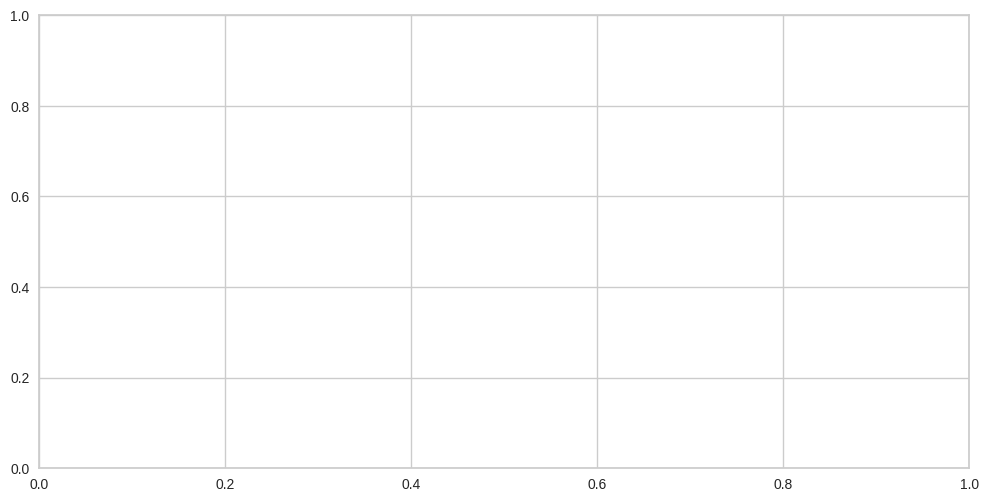

In [83]:
# pycaret model comparisons

from pycaret.classification import *

exp_name = setup(a1_master0.iloc[:idx_split2_9th]
                 , target = 'ac1_pred'
                )

best_model = compare_models()

evaluate_model(best_model)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split the data into training and test sets
a1_X_train = a1_master0.iloc[:idx_split2_9th].drop('ac1_pred', axis=1)
a1_y_train = a1_master0['ac1_pred'].iloc[:idx_split2_9th]
a1_X_test = a1_master0.iloc[idx_split2_9th:idx_split3_9th].drop('ac1_pred', axis=1)
a1_y_test = a1_master0['ac1_pred'].iloc[idx_split2_9th:idx_split3_9th]

X_train = a1_X_train
X_test = a1_X_test
y_train = a1_y_train
y_test = a1_y_test

# Create a logistic regression classifier parameters
# C	1.0
# class_weight	None
# dual	False
# fit_intercept	True
# intercept_scaling	1
# l1_ratio	None
# max_iter	1000
# multi_class	auto
# n_jobs	None
# penalty	l2
# random_state	1906
# solver	lbfgs
# tol	0.0001
# verbose	0
# warm_start	False

clf = LogisticRegression(random_state=1906
                         , C=1.0
                         , class_weight=None
                         , dual=False
                         , fit_intercept=True
                         , intercept_scaling=1
                         , l1_ratio=None
                         , max_iter=1000
                         , multi_class='auto'
                         , n_jobs=-1
                         , penalty='l2'
                         , solver='lbfgs'
                         , tol=0.0001
                         , verbose=0
                         , warm_start=False
                        )

# Train the classifier on the training data
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Evaluate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


In [ ]:
clf.coef_[0]

In [ ]:
importance = clf.coef_[0]
#importance is a list so you can plot it. 
feat_importances = pd.Series(importance)
feat_importances.nlargest(15).plot(kind='barh',title = 'Feature Importance');

In [ ]:
clf.predict(a1_X_pred.to_numpy().reshape(1,-1))[0]

In [ ]:
list(clf.predict_proba(a1_X_pred.to_numpy().reshape(1,-1))[0])

In [ ]:
# random forest classifier
 
from sklearn.metrics import (roc_auc_score
                             , precision_score
                             , recall_score
                             , roc_curve
                             , confusion_matrix
                             , plot_confusion_matrix
                             , precision_recall_curve
                             , auc
                            )

from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.model_selection import GridSearchCV
import joblib

rfc_model = rfc(random_state = 42
                , n_jobs = -1
               )

rfc_model.fit(a1_X_train, a1_y_train)

y_pred = rfc_model.predict(a1_X_test)

acc = accuracy_score(a1_y_test, y_pred)

print(f'Accuaracy: {acc}')

In [ ]:
rfc_model.feature_importances_

In [ ]:
# add predictions to X_train

# idx_split2_9th = int(a.shape[0] * 2.0 / 9)
# idx_split3_9th = int(a.shape[0] * 1.0 / 3)
# idx_split5_9th = int(a.shape[0] * 5.0 / 9)
# idx_split6_9th = int(a.shape[0] * 2.0 / 3)
# idx_split8_9th = int(a.shape[0] * 8.0 / 9)




a1_master1 = a1_master0[a1_col_list].iloc[idx_split3_9th:idx_split6_9th].copy()
a1_master1['pred0'] = xgb_model0.predict(a1_master1[a1_X_train.columns])

idx_2_3 = int(a1_master1.shape[0] * 2 / 3)

a1_X_train = a1_master1.iloc[:idx_2_3].drop('ac1_pred', axis=1)
a1_y_train = a1_master1['ac1_pred'].iloc[:idx_2_3]
a1_X_test = a1_master1.iloc[idx_2_3:].drop('ac1_pred', axis=1)
a1_y_test = a1_master1['ac1_pred'].iloc[idx_2_3:]

In [ ]:
# sanity check first partition for training
print(a1_master1.shape)
print(a1_X_train.shape)
print(a1_y_train.shape)
print(a1_X_test.shape)
print(a1_y_test.shape)

In [ ]:
# modeling partition 2nd 1/3

xgb_model1 = xgb.XGBClassifier(objective='multi:softmax'
                              , num_class=3
                              , random_state=42
                              , max_depth=7
                              , n_estimators=55
                              , learning_rate=0.01
                              , min_child_weight=3
                             )

xgb_model1.fit(a1_X_train, a1_y_train)

y_pred = xgb_model1.predict(a1_X_test)

# y_pred_prob = xgb_model0.predict_proba(a1_X_test)[:, 1]

acc = accuracy_score(a1_y_test, y_pred)

print(f'Accuracy: {acc}')

In [ ]:
xgb_model1.feature_importances_

In [ ]:
# 4/16/2023 --to do: need to put back last row to fill pred0 column

In [ ]:
a1_master1.tail(10)

In [ ]:
a1_master1.shape

In [ ]:
len(a1_X_train.columns)

In [ ]:
a1_X_columns = list(a1_X_train.columns)
a1_X_columns.append('pred0')
a1_X_columns

In [ ]:
a1_X_pred1 = a1_master1[a1_X_columns].iloc[-1].copy()
a1_X_pred1

In [ ]:
a1_master1_scrambled = a1_master1.iloc[:-1].copy()
a1_master1_scrambled.tail(10)

In [ ]:
a1_master1_scrambled = a1_master1_scrambled.sample(frac=1)
a1_master1_scrambled = a1_master1_scrambled.sample(frac=1)

a1_master1_scrambled.tail(10)

In [ ]:
a1_idx_tt_split = int(a1_master1_scrambled.shape[0] * 0.9)
a1_idx_tt_split

In [ ]:
a1_X_train = a1_master1_scrambled[a1_X_columns].iloc[:a1_idx_tt_split]
a1_y_train = a1_master1_scrambled['ac1_pred'].iloc[:a1_idx_tt_split]

a1_X_test = a1_master1_scrambled[a1_X_columns].iloc[a1_idx_tt_split:]
a1_y_test = a1_master1_scrambled['ac1_pred'].iloc[a1_idx_tt_split:]

print(f'a1_master1 shape: {a1_master1.shape}')
print(f'X_train shape: {a1_X_train.shape}')
print(f'y_train shape: {a1_y_train.shape}')
print(f'X_test shape: {a1_X_test.shape}')
print(f'y_test shape: {a1_y_test.shape}')
print(f'a1_X_pred1 shape: {a1_X_pred1.shape}')

In [ ]:
# 2nd modeling

xgb_model1 = xgb.XGBClassifier(objective='binary:logistic'
                              # , num_class=2
                              , random_state=42
                              # , max_depth=7
                              # , n_estimators=89
                              # , learning_rate=0.05
                              # , min_child_weight=4
                             )

xgb_model1.fit(a1_X_train, a1_y_train)

y_pred = xgb_model1.predict(a1_X_test)

y_pred_prob = xgb_model1.predict_proba(a1_X_test)[:, 1]

acc = accuracy_score(a1_y_test, y_pred)

print(f'Accuracy: {acc}')

In [ ]:
xgb_model1.feature_importances_

In [ ]:
a1_X_columns